In [1]:
!pip install torch torchvision

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 66.5/66.5 MB 13.6 MB/s eta 0:00:0000:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 6.2/6.2 MB 14.6 MB/s eta 0:00:00a 0:00:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.8/1.8 MB 14.4 MB/s eta 0:00:0000:0100:01
  Attempting uninstall: sympy
    Found existing installation: sympy 1.12
    Uninstalling sympy-1.12:
      Successfully uninstalled sympy-1.12


In [3]:
# For tips on running notebooks in Google Colab, see
# https://pytorch.org/tutorials/beginner/colab
%matplotlib inline

In [3]:
import torch
from torch import nn
from torch.utils.data import DataLoader
from torchvision import datasets
from torchvision.transforms import ToTensor
from torchvision import transforms

In [5]:
# Define the training data transformations with augmentations
train_transform = transforms.Compose([
    transforms.RandomRotation(15),           # Rotate randomly within ±15 degrees
    transforms.RandomAffine(degrees=10, translate=(0.1, 0.1),scale=(0.9, 1.1)),  # Random shifts
    transforms.ToTensor(),                   # Convert to tensor
    transforms.Normalize((0.1307,), (0.3081,))  # Normalize (same as MNIST)
])

# Define the test data transformations (NO AUGMENTATION)
test_transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.1307,), (0.3081,))
])

In [7]:
# Download training data from open datasets.
training_data = datasets.MNIST(
    root="data",
    train=True,
    download=True,
    #transform=ToTensor(),
    transform=train_transform,
)

# Download test data from open datasets.
test_data = datasets.MNIST(
    root="data",
    train=False,
    download=True,
    #transform=ToTensor(),
    transform=test_transform,
)

In [9]:
batch_size = 64

# Create data loaders.
train_dataloader = DataLoader(training_data, batch_size=batch_size)
test_dataloader = DataLoader(test_data, batch_size=batch_size)

for X, y in test_dataloader:
    print(f"Shape of X [N, C, H, W]: {X.shape}")
    print(f"Shape of y: {y.shape} {y.dtype}")
    break

Shape of X [N, C, H, W]: torch.Size([64, 1, 28, 28])
Shape of y: torch.Size([64]) torch.int64


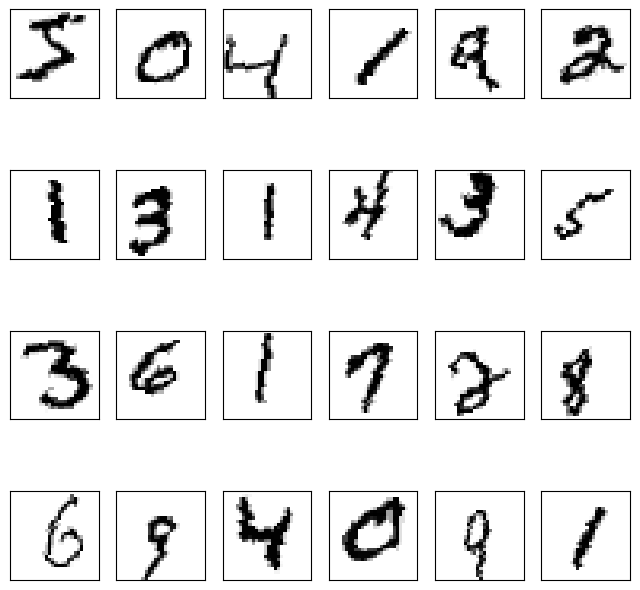

In [11]:
import matplotlib.pyplot as plt
plt.figure(figsize=(8,8))
data_iter = iter(train_dataloader)
images, labels = next(data_iter)
for i in range(24):
    plt.subplot(4,6,i+1)
    plt.xticks([])
    plt.yticks([])
    plt.grid(False)
    image_to_display = images[i].permute(1, 2, 0).numpy()
    # CIFAR10 images are normalized from [-1, 1], undo that for proper visualization
    image_to_display = (image_to_display * 0.5) + 0.5  # Unnormalize
    plt.imshow(image_to_display, cmap=plt.cm.binary)
plt.show()

In [13]:
device = torch.accelerator.current_accelerator().type if torch.accelerator.is_available() else "cpu"
print(f"Using {device} device")

# Define model
class NeuralNetwork(nn.Module):
    def __init__(self):
        super().__init__()
        self.flatten = nn.Flatten()
        # self.linear_relu_stack = nn.Sequential(
        #     nn.Linear(28*28, 512),
        #     nn.ReLU(),
        #     nn.Linear(512, 512),
        #     nn.ReLU(),
        #     nn.Linear(512, 10)
        self.conv2d = nn.Sequential(     
            nn.Conv2d(1, 32, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2),
            
            nn.Conv2d(32, 64, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2),
            
            nn.Flatten(),
            nn.Linear(64 * 7 * 7, 128),
            nn.ReLU(),
            nn.Linear(128, 10)
        )

    def forward(self, x):
        # x = self.flatten(x)
        logits = self.conv2d(x)
        return logits

model = NeuralNetwork().to(device)
print(model)

Using mps device
NeuralNetwork(
  (flatten): Flatten(start_dim=1, end_dim=-1)
  (conv2d): Sequential(
    (0): Conv2d(1, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU()
    (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (3): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (4): ReLU()
    (5): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (6): Flatten(start_dim=1, end_dim=-1)
    (7): Linear(in_features=3136, out_features=128, bias=True)
    (8): ReLU()
    (9): Linear(in_features=128, out_features=10, bias=True)
  )
)


In [15]:
loss_fn = nn.CrossEntropyLoss()
#optimizer = torch.optim.SGD(model.parameters(), lr=1e-3)
optimizer = torch.optim.Adam(model.parameters(), lr=0.0001)

In a single training loop, the model makes predictions on the training
dataset (fed to it in batches), and backpropagates the prediction error
to adjust the model\'s parameters.


In [18]:
def train(dataloader, model, loss_fn, optimizer):
    size = len(dataloader.dataset)
    model.train()
    for batch, (X, y) in enumerate(dataloader):
        X, y = X.to(device), y.to(device)

        # Compute prediction error
        pred = model(X)
        loss = loss_fn(pred, y)

        # Backpropagation
        loss.backward()
        optimizer.step()
        optimizer.zero_grad()

        if batch % 100 == 0:
            loss, current = loss.item(), (batch + 1) * len(X)
            print(f"loss: {loss:>7f}  [{current:>5d}/{size:>5d}]")

We also check the model\'s performance against the test dataset to
ensure it is learning.


In [21]:
def test(dataloader, model, loss_fn):
    size = len(dataloader.dataset)
    num_batches = len(dataloader)
    model.eval()
    test_loss, correct = 0, 0
    with torch.no_grad():
        for X, y in dataloader:
            X, y = X.to(device), y.to(device)
            pred = model(X)
            test_loss += loss_fn(pred, y).item()
            correct += (pred.argmax(1) == y).type(torch.float).sum().item()
    test_loss /= num_batches
    correct /= size
    print(f"Test Error: \n Accuracy: {(100*correct):>0.1f}%, Avg loss: {test_loss:>8f} \n")

The training process is conducted over several iterations (*epochs*).
During each epoch, the model learns parameters to make better
predictions. We print the model\'s accuracy and loss at each epoch;
we\'d like to see the accuracy increase and the loss decrease with every
epoch.


In [28]:
epochs = 5
for t in range(epochs):
    print(f"Epoch {t+1}\n-------------------------------")
    train(train_dataloader, model, loss_fn, optimizer)
    test(test_dataloader, model, loss_fn)
print("Done!")

Epoch 1
-------------------------------
loss: 2.303448  [   64/60000]
loss: 1.394878  [ 6464/60000]
loss: 1.024628  [12864/60000]
loss: 0.791424  [19264/60000]
loss: 0.607146  [25664/60000]
loss: 0.547110  [32064/60000]
loss: 0.671006  [38464/60000]
loss: 0.515283  [44864/60000]
loss: 0.573751  [51264/60000]
loss: 0.330147  [57664/60000]
Test Error: 
 Accuracy: 95.4%, Avg loss: 0.154267 

Epoch 2
-------------------------------
loss: 0.333335  [   64/60000]
loss: 0.264376  [ 6464/60000]
loss: 0.184559  [12864/60000]
loss: 0.336009  [19264/60000]
loss: 0.260729  [25664/60000]
loss: 0.387015  [32064/60000]
loss: 0.203613  [38464/60000]
loss: 0.335120  [44864/60000]
loss: 0.382009  [51264/60000]
loss: 0.289432  [57664/60000]
Test Error: 
 Accuracy: 96.7%, Avg loss: 0.107640 

Epoch 3
-------------------------------
loss: 0.137307  [   64/60000]
loss: 0.317251  [ 6464/60000]
loss: 0.193711  [12864/60000]
loss: 0.222113  [19264/60000]
loss: 0.217137  [25664/60000]
loss: 0.265002  [32064/600

In [30]:
torch.save(model.state_dict(), "/Users/wellingtonramoschevreuil/Projects/digit-recognition/service/digit_model_cv2d-3.pth")

Loading Models
==============

The process for loading a model includes re-creating the model structure
and loading the state dictionary into it.


In [33]:
print(device)

mps


In [35]:
model = NeuralNetwork().to(device)
#model.load_state_dict(torch.load("digit_model.pth", weights_only=True))
model.load_state_dict(torch.load("/Users/wellingtonramoschevreuil/Projects/digit-recognition/service/digit_model_cv2d-3.pth", weights_only=True))

<All keys matched successfully>

In [41]:
classes = [
    "0",
    "1",
    "2",
    "3",
    "4",
    "5",
    "6",
    "7",
    "8",
    "9",
]

model.eval()
# x, y = test_data[3]
correct_count = 0
for x,y in test_dataloader:
    with torch.no_grad():
        x = x.to(device)
        pred = model(x)
        pred_probab = nn.Softmax(dim=1)(pred)

        for i in range(x.shape[0]):  # Loop through batch
            predicted = classes[pred[i].argmax(0).item()]  # Convert to int
            actual = classes[y[i].item()]  # Convert label tensor to int
            if predicted == actual:
                correct_count = correct_count+1;
            #print(f'Predicted: "{predicted}", Actual: "{actual}"')
print(f'Accuracy: "{correct_count/len(test_data)}"')

Accuracy: "0.982"
